In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

from itertools import product

In [2]:
# Read in csv
cluster_data = pd.read_csv('./Data/cluster_data.csv')
cluster_data.head()

# Noticed outliers in dendrogram, seeing if taking them out makes a difference
# TODO take out
# cluster_data.drop(index=[598, 415, 264, 187, 90, 633, 631, 404, 424], inplace=True)

,cust_id,avg(amount/tran),credit_balance,savings_balance,checking_balance,income,age,years_with_bank,nbr_children,gender,city_name
0,1362480,269.266706,20.00,1187.97,86.86,50890,33,3,2,M,New York City
1,1362484,381.386000,369.72,2122.17,95.32,10053,42,2,0,F,Denver
2,1362485,278.479306,1100.00,0.00,45.49,22690,25,4,0,F,New York City
3,1362486,98.289600,0.00,116.24,3312.27,10701,76,6,0,F,Dallas
4,1362487,211.563389,1548.23,12.89,1401.21,6605,71,1,0,M,Los Angeles


In [3]:
# Prepare data for banking behavior clustering
# Drop customer id, age, number of children, gender, city name
banking_data_raw = cluster_data.drop(columns=['cust_id', 'age', 'nbr_children', 'gender', 'city_name'])
# Log1p transform to avoid infinities
banking_data_log = banking_data_raw.copy()
financial_cols = [col for col in banking_data_raw.columns if col != 'years_with_bank']
banking_data_log[financial_cols] = banking_data_raw[financial_cols].apply(np.log1p)
banking_data_log.head()


,avg(amount/tran),credit_balance,savings_balance,checking_balance,income,years_with_bank
0,5.599409,3.044522,7.080843,4.475745,10.837441,3
1,5.946431,5.915447,7.660666,4.567676,9.215726,2
2,5.632928,7.003974,0.000000,3.839237,10.029724,4
3,4.598041,0.000000,4.764223,8.105691,9.278186,6
4,5.359240,7.345513,2.631169,7.245805,8.795734,1


In [4]:
# Scale remaining columns
scaler = StandardScaler().set_output(transform='pandas')
banking_data_scaled = scaler.fit_transform(banking_data_log)
banking_data_scaled.head()

,avg(amount/tran),credit_balance,savings_balance,checking_balance,income,years_with_bank
0,0.372295,-0.423076,0.920967,0.242033,0.666026,-0.303070
1,0.706335,0.458144,1.100162,0.274386,0.170854,-0.674388
2,0.404560,0.792263,-1.267386,0.018036,0.419399,0.068249
3,-0.591614,-1.357581,0.205009,1.519471,0.189925,0.810885
4,0.141110,0.897097,-0.454217,1.216863,0.042614,-1.045707


In [5]:
# KMeans

# Hyperparameters
# 3-5 Clusters specified by readme, trying 2-6 for education
ClusterRange = range(2, 7)

model_KMeans = None
X = banking_data_scaled
inertias_KMeans = []
labels = None
silhouettes_KMeans = []

for k in ClusterRange:
    # Instantiate
    model_KMeans = KMeans(n_clusters = k)
    # Train
    model_KMeans.fit(X)
    # Store inertias
    inertias_KMeans.append(model_KMeans.inertia_)
    # Store silhouettes
    labels = model_KMeans.predict(X)
    silhouettes_KMeans.append(silhouette_score(X, labels))


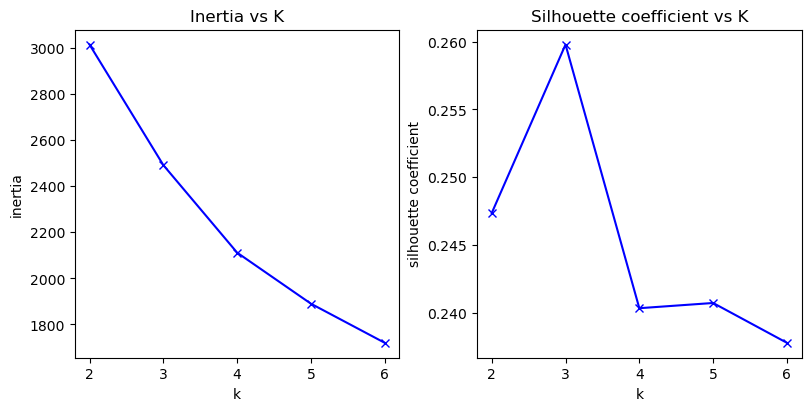

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8, 4))

ax[0].plot(ClusterRange, inertias_KMeans, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_title('Inertia vs K')

ax[1].plot(ClusterRange, silhouettes_KMeans, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette coefficient')
ax[1].set_title('Silhouette coefficient vs K')

plt.show()

In [7]:
# KMeans Conclusions
# Elbow method inconclusive
# Silhouette coefficient indicates 3 clusters is clearly best

In [8]:
# Hierarchical Clustering

# Hyperparameters
Linkages = ['ward', 'complete', 'average', 'single']
ClusterRange = ClusterRange

model_Agg = None
X = banking_data_scaled
labels = None
silhouettes_Agg = { link : [] for link in Linkages }

for link in Linkages:
    for k in ClusterRange:
        # Instantiate
        model_Agg = AgglomerativeClustering(n_clusters = k, linkage = link)
        # Train
        labels = model_Agg.fit_predict(X)
        # Store silhouettes
        silhouettes_Agg[link].append(silhouette_score(X, labels))



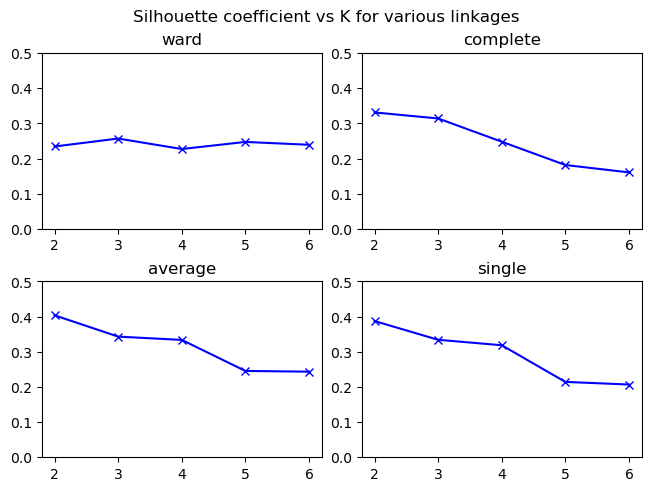

In [9]:
# plot silhouette coefficients
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
link_idx = 0
for row in ax:
    for col in row:
        link = Linkages[link_idx]
        col.plot(ClusterRange, silhouettes_Agg[link], 'bx-')
        col.set_title(link)
        col.set_ylim([0, 0.5])
        link_idx += 1
fig.suptitle("Silhouette coefficient vs K for various linkages")
plt.show()


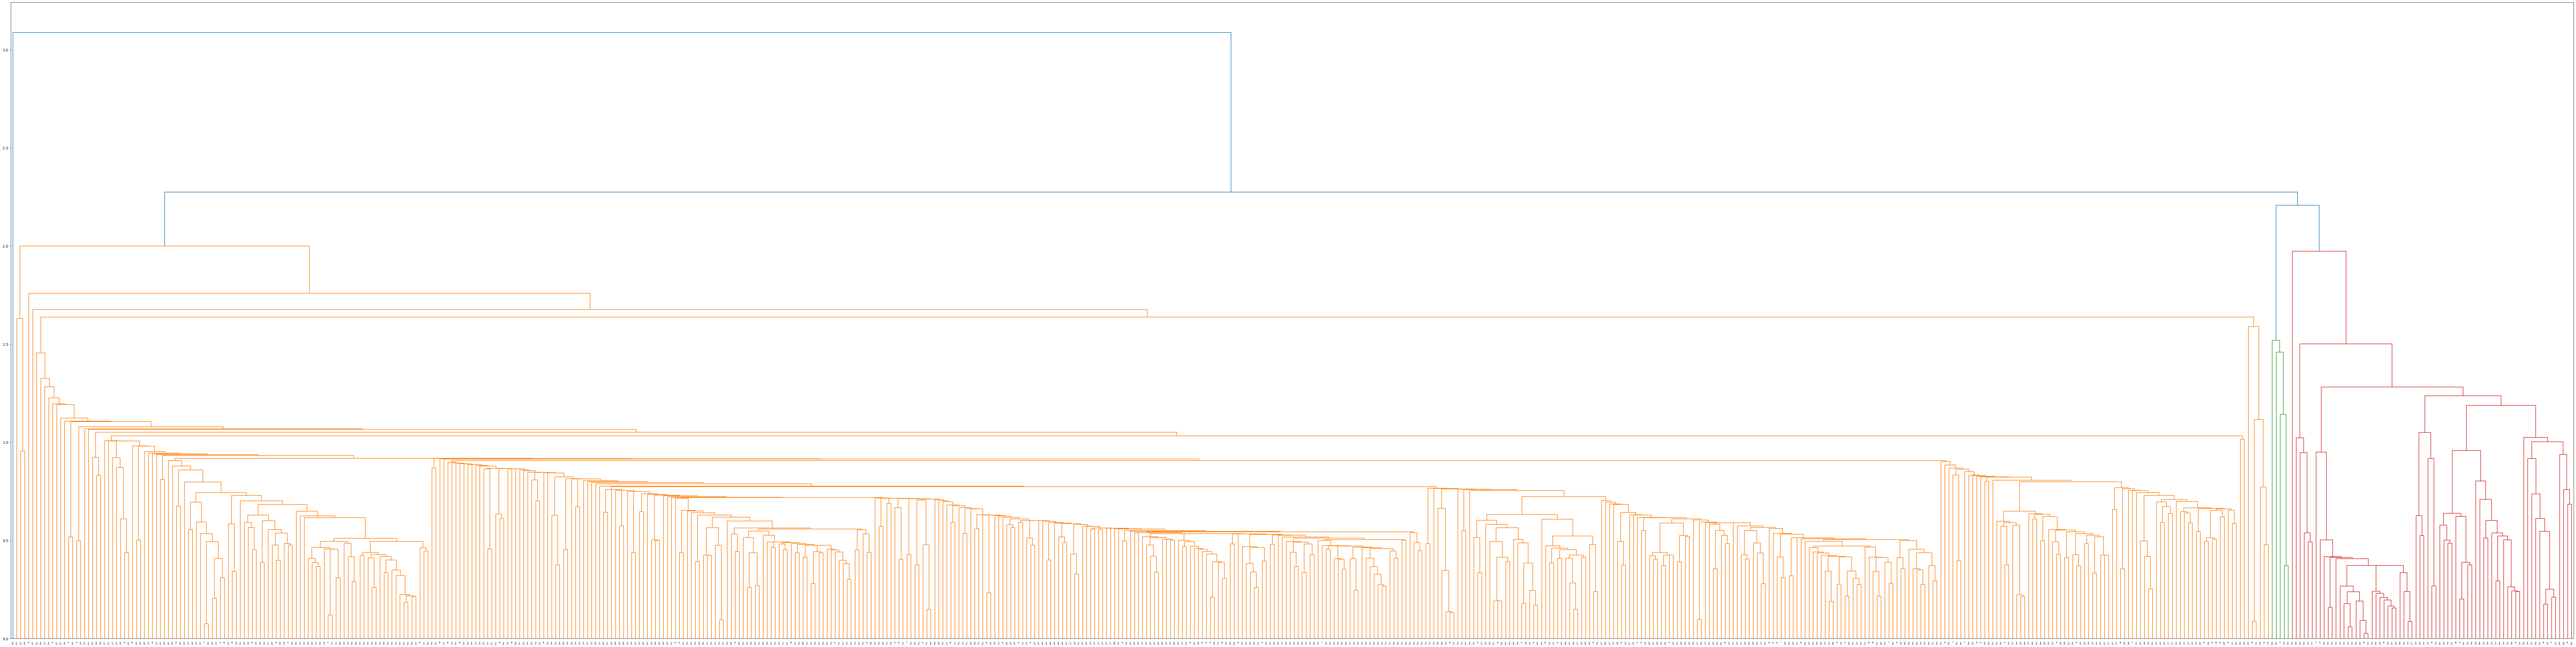

In [10]:
#plot dendrogram
linkage_matrix = linkage(X)

plt.figure(figsize=(128, 32))
dendrogram(linkage_matrix)
plt.show()

In [11]:
# Hierarchical Clustering conclusions
# Silhouettes of various linkages lean towards 3 clusters
# Dendrogram can pick out outliers which can change the outcome if dropped

In [12]:
# DBSCAN

# Hyperparameters
R = [0.8, 1, 1.2, 1.4, 1.6]
M = [4, 5, 6, 7, 8, 9]
HParams = list(product(R, M))
HParam_shape = (len(R), len(M))

model_DB = None
X = banking_data_scaled
labels = None
silhouettes_DB = np.zeros(HParam_shape)
n_clusters = np.zeros(HParam_shape)
n_outliers = np.zeros(HParam_shape)
outlier_mask = None
score = 0

for i in range(len(R)):
    for j in range(len(M)):
        # Instantiate
        model_DB = DBSCAN(eps = R[i], min_samples = M[j])
        # Train
        model_DB.fit(X)
        labels = model_DB.labels_
        # Count number of clusters and outliers found
        n_clusters[i][j] = len(set(labels)) - (1 if -1 in labels else 0) #number of unique clusters labels (excluding -1)
        n_outliers[i][j] = list(labels).count(-1) #counts how many outliers there are (labels with -1)
        # Mask outliers before silhouette score
        outlier_mask = labels >= 0
        # Store silhouettes
        try:
            score = silhouette_score(X[outlier_mask], labels[outlier_mask])
        except:
            # If DBSCAN finds less than 2 clusters, silhouette score throws an error. define as 0
            score = 0
        finally:
            silhouettes_DB[i][j] = score

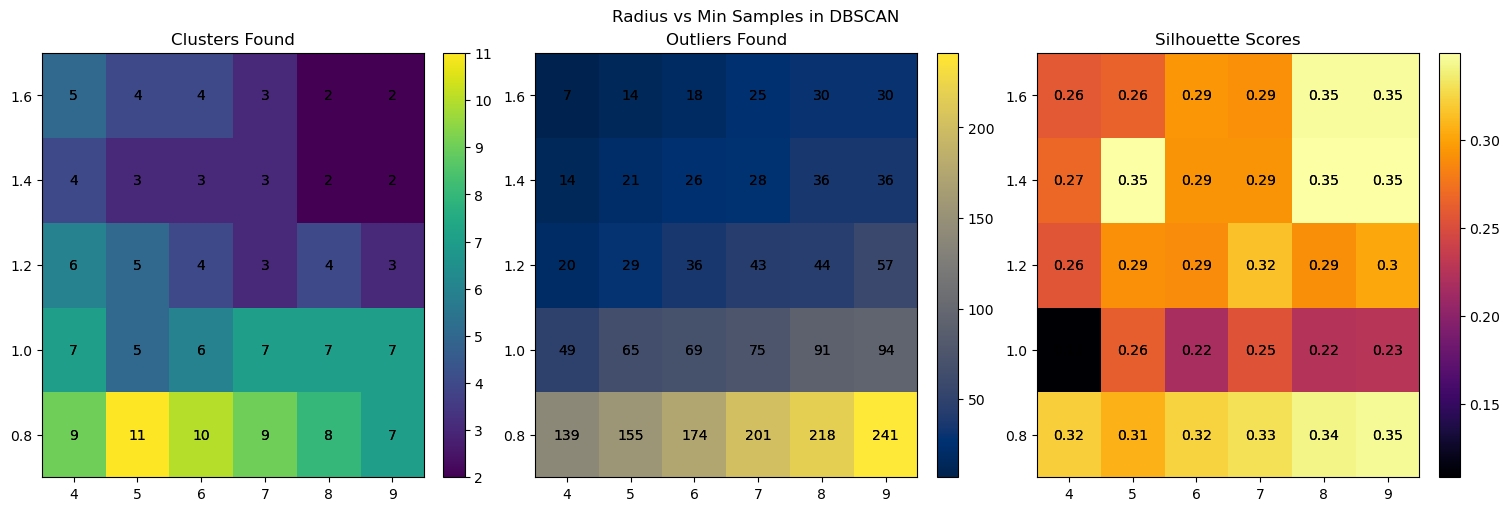

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15, 5))
pcm_clust = ax[0].pcolormesh(M, R, n_clusters, shading='auto')
ax[0].set_xticks(M)
ax[0].set_yticks(R)
ax[0].set_title('Clusters Found')
for (j,i),label in np.ndenumerate(n_clusters):
    label = int(label)
    ax[0].text(M[i],R[j],label,ha='center',va='center')
    ax[0].text(M[i],R[j],label,ha='center',va='center')
fig.colorbar(pcm_clust, ax=ax[0])

pcm_out = ax[1].pcolormesh(M, R, n_outliers, shading='auto', cmap='cividis')
ax[1].set_xticks(M)
ax[1].set_yticks(R)
ax[1].set_title('Outliers Found')
for (j,i),label in np.ndenumerate(n_outliers):
    label = int(label)
    ax[1].text(M[i],R[j],label,ha='center',va='center')
    ax[1].text(M[i],R[j],label,ha='center',va='center')
fig.colorbar(pcm_out, ax=ax[1])

pcm_sil = ax[2].pcolormesh(M, R, silhouettes_DB, shading='auto', cmap='inferno')
ax[2].set_xticks(M)
ax[2].set_yticks(R)
ax[2].set_title('Silhouette Scores')
for (j,i),label in np.ndenumerate(silhouettes_DB):
    label = round(label, 2)
    ax[2].text(M[i],R[j],label,ha='center',va='center')
    ax[2].text(M[i],R[j],label,ha='center',va='center')
fig.colorbar(pcm_sil, ax=ax[2])

fig.suptitle('Radius vs Min Samples in DBSCAN')
plt.show()

In [14]:
# DBSCAN Conclusions
# Many outliers
# If goal is 3-5 clusters:
# Select radius of 1.4 and min samples of 5 
# Gives 3 clusters with a relatively high silhouette score and a low number of outliers

In [15]:
# Radar plots
# Return to KMeans with k = 3
# Instantiate
model_KMeans = KMeans(n_clusters = 3)
X = banking_data_scaled
labels = None
# Train
labels = model_KMeans.fit_predict(X)
# Get mean cluster samples
cluster_0_means = banking_data_log[labels == 0].mean()
cluster_1_means = banking_data_log[labels == 1].mean()
cluster_2_means = banking_data_log[labels == 2].mean()
cluster_means = pd.DataFrame([cluster_0_means, cluster_1_means, cluster_2_means])
cluster_means


,avg(amount/tran),credit_balance,savings_balance,checking_balance,income,years_with_bank
0,4.430796,2.208263,5.428989,1.844576,0.000000,3.052632
1,4.537834,0.352237,3.579510,4.066401,9.778168,3.485714
2,5.666642,6.675211,4.076073,4.041123,9.836527,4.112532


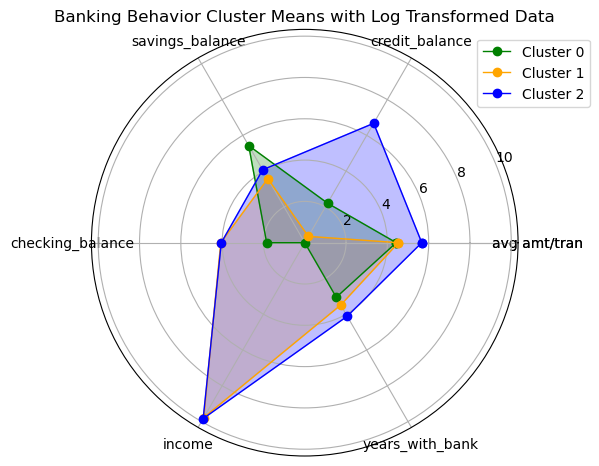

In [16]:
# Obtain angles for radar plots
angles=np.linspace(0,2*np.pi,len(cluster_means.columns), endpoint=False)
# Append 0th column for radar plots
angles=np.concatenate((angles,[angles[0]]))
cluster_0_means['avg amt/tran'] = cluster_0_means['avg(amount/tran)']
cluster_1_means['avg amt/tran'] = cluster_1_means['avg(amount/tran)']
cluster_2_means['avg amt/tran'] = cluster_2_means['avg(amount/tran)']

# Radar plot
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111, polar=True)
# Cluster 0 Plot
ax.plot(angles, cluster_0_means, 'o-', color='g', linewidth=1, label='Cluster 0')
ax.fill(angles, cluster_0_means, alpha=0.25, color='g')
# Cluster 1 Plot
ax.plot(angles, cluster_1_means, 'o-', color='orange', linewidth=1, label='Cluster 1')
ax.fill(angles, cluster_1_means, alpha=0.25, color='orange')
# Cluster 2 Plot
ax.plot(angles, cluster_2_means, 'o-', color='b', linewidth=1, label='Cluster 2')
ax.fill(angles, cluster_2_means, alpha=0.25, color='b')

ax.set_thetagrids(angles * 180/np.pi, cluster_0_means.index)
plt.grid(True)
plt.tight_layout()
plt.title('Banking Behavior Cluster Means with Log Transformed Data')
plt.legend(bbox_to_anchor=(1,0.85), loc='upper right', bbox_transform=plt.gcf().transFigure)
plt.show()

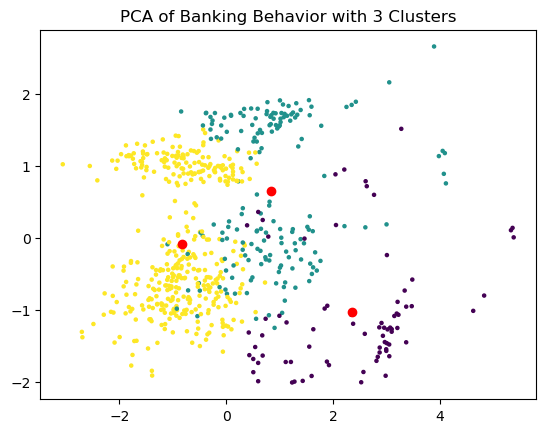

In [17]:
# PCA
pca = PCA(n_components=2).set_output(transform="pandas")
df_pca = pca.fit_transform(banking_data_scaled) 
df_pca['label'] = labels
pca_centroids = pca.transform(model_KMeans.cluster_centers_)
plt.scatter(df_pca['pca0'], df_pca['pca1'], c=df_pca['label'], s=5)
plt.scatter(pca_centroids['pca0'], pca_centroids['pca1'], c='red')
plt.title('PCA of Banking Behavior with 3 Clusters')
plt.show()